# PyironFlow: a visual programming environment for pyiron_workflows

Author: Jörg Neugebauer

Date: Aug. 16, 2024

Key concepts:
- Strict separartion between logical/programmatic part (handled by pyiron_workflows) and gui (handled by a combination of reactflow, a react javascript tool, and ipywidgets to connect to the jupyter ecosystem)
- The communication between python and .jsx is handled via traitlets
- Graphical and programmatic representation of a workflow, described by its nodes and edges, is fully echangable. The two representations can be seemlessly interchanged, i.e. you can start writing the workflow as code and then transfer it to the gui to extend or run it 

### Setup configuration

#### Include the pyiron_node library into PYTHONPATH (modules need to be importable)

In [ ]:
%config IPCompleter.evaluation='unsafe'

import sys
from pathlib import Path
sys.path.insert(0, str(Path(Path.cwd()).parent) + '/pyiron_nodes')

#### When creating a new conda environment or react widget install the following tools 

Note: You have to install via conda-forge: 
- nodejs
- esbuild
- anywidget

Uncomment the line below to install the following modules (.jsx side)

In [ ]:
# !npm install react react-dom @xyflow/react @anywidget/react

#### Run the following line whenever you modify a file in the js/ (javascript) directory 

In [ ]:
!npx esbuild js/widget.jsx --minify --format=esm --bundle --outdir=static

## Simple Demonstrator (How to use *anywidget* to build a reactflow widget)

In [ ]:
import anywidget
import pathlib
import traitlets
import os
import json

In [ ]:
class ReactFlowWidget(anywidget.AnyWidget):
    path = pathlib.Path(os.getcwd()) / 'static' 
    _esm = path / "widget.js"
    _css = path / "widget.css"
    nodes = traitlets.Unicode('[]').tag(sync=True)
    edges = traitlets.Unicode('[]').tag(sync=True)
    commands = traitlets.Unicode('[]').tag(sync=True)

### Create an empty reactflow window

In [ ]:
w = ReactFlowWidget()
w

#### Create some nodes and load them into the widget (to see the effect go back the the frame above)

Note: We have to convert the nodes dictionary to json to load it

In [ ]:
nodes = [
    {
      'id': '1',
      'data': { 'label': 'Hello' },
      'position': { 'x': 0, 'y': 0 },
      'type': 'input',
      'sourcePosition': 'right',
    },
    {
      'id': '2',
      'data': { 'label': 'message' },
      'position': { 'x': 250, 'y': 100 },
      'type': 'output',
      'targetPosition': 'left',      
    },
    {
      'id': '3',
      'data': { 'label': 'my_node_1', 
               'source_labels': ['a', 'b'],
               'target_labels': ['in1', 'in_2', 'in_3'],
               'target_values': ['1', None, 2],
              },
      'position': { 'x': 0, 'y': 100 },
      'type': 'customNode',
      'style': {
              'border': '1px black solid',
              'padding': 5,
              'background': '#999',
              'borderRadius': '10px',
              'width': '200px',
            },    
      'targetPosition': 'left',  
      'sourcePosition': 'right',  
    },
    {
      'id': '4',
      'data': { 'label': 'my_node_2', 
               'source_labels': ['a', 'c', '12'],
               'target_labels': ['in1', 'in_2'],
               'target_values': ['1', None],
              },
      'position': { 'x': 300, 'y': 160 },
      'type': 'customNode',
      'style': {
              'border': '1px black solid',
              'padding': 20,
              'background': '#1999',
            },    
      'targetPosition': 'left',  
      'sourcePosition': 'right',  
    }
]

nodes_json = json.dumps(nodes)
w.nodes = nodes_json

Play a bit with the widget. Move the nodes, connect the node handles. You can get all the changes you did graphicall via the nodes and edges property of the widget:

In [ ]:
json.loads(w.edges)

## PyironFlow Gui

#### Definition via workflow

In [ ]:
!npx esbuild js/widget.jsx --format=esm --bundle --outdir=static

In [1]:
!npx esbuild js/widget.jsx --minify --format=esm --bundle --outdir=static

⠙
  static/widget.js   308.5kb
  static/widget.css   15.1kb

⚡ Done in 38ms
⠙

In [1]:
%config IPCompleter.evaluation='unsafe'

import sys
from pathlib import Path
sys.path.insert(0, str(Path(Path.cwd()).parent) + '/pyiron_nodes')

### Create two example workflows (to compute elastic constants and an empty one)

In [3]:
from pyiron_workflow import Workflow   

Workflow.register("node_library.atomistic", "atomistic") 

wf = Workflow('compute_elastic_constants')
wf.engine = wf.create.atomistic.engine.ase.M3GNet()
wf.bulk = wf.create.atomistic.structure.build.bulk('Al', cubic=True)
wf.elastic = wf.create.atomistic.property.elastic.elastic_constants(structure=wf.bulk, engine=wf.engine) #, parameters=parameters)
# out = elastic.pull()

wf_new = Workflow('new_workflow')

In [6]:
from python.pyironflow import PyironFlow

pf = PyironFlow([wf])
pf.gui

### Get the grapically build or modified workflow

In [ ]:
wf = pf.get_workflow()
wf.bulk.outputs.channel_dict['structure'].value

In [ ]:
pf.wf_widgets[0].gui.nodes

### You can return the workflow back to the gui 

Note: 
- all the nodes and connections are reproduced
- the node positions are presently not stored, you have to place them manually

In [ ]:
wf = pf.get_workflow()
pf2 = PyironFlow([wf])
pf2.gui

#### Get the nodes of the graphically represented workflow (remove the semicolon)

In [ ]:
import json
json.loads(pf.wf_widgets[0].gui.nodes);

#### Run the workflow manually (you can also do this in the gui)

In [ ]:
out = wf.run()

#### Open the log window for debugging

In [ ]:
pf.out_log

TODO:
  - create new label if same node is included multiple times in the same workflow (feature should be provided on the pyiron_workflow side)
  - Include values at ports (if simple data structures)
  - Tree view for new nodes
  - add top buttons: 'run' (entire workflow)
  - automatic arrangement of nodes
  - Allow editing input channels (e.g. chemical element)
  - Keep state of a node persistent, i.e., if had had run the output etc. should be available without rerunning (keep workflow instance if no changes have been applied)
  - Bugs:
      - node with multiple outputs cannot be jsonified (get_import_path(node) fails)

### Ideas, concepts

The follwoing ipywidget may be useful (e.g. to replace the tabs)

In [26]:
from ipywidgets import TagsInput
tabs = TagsInput(
    value=['pizza', 'fries'],
    # allowed_tags=['pizza', 'fries', 'tomatoes', 'steak'],
    allow_duplicates=False
)
tabs

TagsInput(value=['pizza', 'fries'], allow_duplicates=False, tabbable=False)

In [27]:
import ipywidgets as widgets
from traitlets import Tuple, Any, Unicode, Enum, Int, observe, validate, link

class InputTags(widgets.HBox, widgets.ValueWidget):
    allowed_tags = Tuple(allow_none=True)
    max_tags = Int(allow_none=True, default_value=None, min=1)
    options = Tuple()
    value = Any()
    description = Unicode()
    allowed_type = Enum((str,float,None))
    _suggestions = Tuple()
    def __init__(self, value=None, description=None, allowed_tags=None, allowed_type=str, max_tags=None, color=None, options=None, **kwargs):
        '''value=None, description=None, allowed_tags=None, max_tags=None, color=None'''
        self._cbox = widgets.Combobox(layout=widgets.Layout(min_width='110px', flex='1', margin = '2px -5px 0px 2px'), 
                                      placeholder = "type or select")
        super().__init__(**kwargs)
        if description is None:
            description=''
        self.max_tags = max_tags
        self._btn_color = color
        self._btns_cont = widgets.HBox([self._cbox], layout=dict(flex='1', min_width='220px'))
        self.slct_all_btn = widgets.Button(icon='angle-double-left', tooltip='select all', button_style='info', 
                                           layout=dict(min_width='32px', width='auto', margin='2px -2px 0px 2px'))
        self.clear_all_btn = widgets.Button(icon='times', tooltip='clear all', button_style='warning', 
                                            layout=dict(min_width='32px', width='auto', margin='2px 0px 0px 2px'))
        self.validate_btn = widgets.Button(icon='check', tooltip='add to queue', button_style='success', 
                                           layout=dict(min_width='32px', width='auto', margin='2px 0px 0px 2px'))
        self.validate_btn.on_click(lambda b: self.submit())
        self.validate_btn_container = widgets.HBox(layout=dict(margin='0px -2px -2px 0px'))
        self.slct_all_btn.on_click(lambda b: self.select_all_startwith(self._cbox.value))
        self.clear_all_btn.on_click(lambda b: self.clear_cbox())
        self._cbox.observe(self.on_T_change, names='value')
        self._cbox.on_submit(lambda change: self.submit())
        self.buttons = widgets.HBox([self._btns_cont], layout=dict(flex='1', flex_flow='wrap', margin='1px'))
        self._description_widget = widgets.HTML()
        self.children = [self._description_widget, self.buttons]
        self.description = description
        self.allowed_type = allowed_type
        self.allowed_tags = allowed_tags
        link((self._cbox, 'options'), (self, '_suggestions'))
        self.options = options if options is not None else ()
        self.value = value if value is not None else ()
        
    def _isvalid(self, obj):
        #allowed_type = (float, int) if self.allowed_type==float else self.allowed_type
        if obj is None or isinstance(obj, (list,tuple)):
            return True
        #elif obj and isinstance(obj, (list, tuple)):
        #    return all(isinstance(s, allowed_type) for s in obj)
        else:
            return False

    @observe('description')
    def _observe_description(self, change):
        desc = change.new
        value = f'''<font "{self._btn_color}">{desc}</font>'''
        width = '86px' if desc!='' else '0px'
        self._description_widget.value = value
        self._description_widget.layout.width = width
    
    def _validate_value_type(self, val, allowed_type, allowed_tags=None):
        if val is None:
            val = ()
        val_new = []
        for v in val:
            if str(v).strip()!='':
                if allowed_tags is None or \
                    (allowed_tags is not None and v in allowed_tags):
                    try:
                        v = allowed_type(v)
                        val_new.append(v)
                    except ValueError:
                        pass
        return tuple(val_new)


    @validate('allowed_tags')
    def _valid_allowed_tags(self, proposal):
        val = proposal['value']
        if all(isinstance(v,(float,int)) for v in val):
            val = tuple(float(v) for v in val)
        else:
            val = tuple(str(v) for v in val)
        return val

    @observe('allowed_tags')
    def _observe_allowed_tags(self, change):
        val = change.new
        if val is not None:
            if val and isinstance(val[0], float):
                self.allowed_type = float
            else:
                self.allowed_type = str
            self.options = val
            if self.value is not None:
                self.value = tuple(v for v in self.value if v in val)
    
    @observe('allowed_type')
    def _observe_allowed_type(self, change):
        self.value = self._validate_value_type(self.value, allowed_type=change.new)
        if self.allowed_tags is not None:
            at = self._validate_value_type(self.allowed_tags, allowed_type=change.new)
            if not at:
                at = None
            self.allowed_tags = at

    @validate('options')
    def _valid_options(self, proposal):
        val = proposal['value']
        opts = self._validate_value_type(val, allowed_type=self.allowed_type, allowed_tags=self.allowed_tags)
        if self.allowed_tags is not None:
           opts = tuple(sorted(set(opts+self.allowed_tags)))
        return opts

    @observe('value','options')
    def _update_suggestions(self, change):
        opts = set(self.options).difference(set(self.value))
        self._suggestions = sorted(tuple(str(o) for o in opts))
        
    @validate('value')
    def _valid_value(self, proposal):
        val = proposal['value']
        assert self._isvalid(val), f'{val} of type {type(val)} must be a list or tuple of {self.allowed_type}'
        newval = self._validate_value_type(val, allowed_type=self.allowed_type, allowed_tags=self.allowed_tags)
        return tuple(sorted(self.allowed_type(v) for v in newval))[:self.max_tags]
    
    @observe('value')
    def _observe_value(self, change):
        btns = [b for b in self.buttons.children[:-1] if b.description in change.new]
        oldval = [] if change.old is None else change.old
        for v in change.new:
            if v not in oldval:
                desc = f"'{v}'" if self.allowed_type is str else f"{v}"
                button = widgets.Button(description = desc, tooltip=str(v), disabled=True,
                                        layout=dict(width='auto'),
                                        style=dict(button_color=self._btn_color))
                close_btn = widgets.Button(icon='times', 
                                            layout=dict(width='32px', margin='0px -5px 0px 0px'),
                                            style=dict(button_color=self._btn_color))
                close_btn.on_click(self._on_close_button_click)
                bbox=widgets.HBox([close_btn,button], layout=dict(align_items='center', width='auto'))
                bbox.description = close_btn.tag = v
                bbox.tag = 'entry'
                btns.append(bbox)
        self._cbox.value = ''
        opts = set(self.options+self.value)
        self.options = tuple(opts)
        if self.allowed_tags is None or len(self.allowed_tags) != len(btns):
            self._btns_cont.children = (self._cbox, self.validate_btn_container, self.slct_all_btn, self.clear_all_btn)
        elif not self.value:
            self._btns_cont.children = (self._cbox, self.clear_all_btn,)
        else:
            self._btns_cont.children = (self.clear_all_btn,)
        self.buttons.children = btns + [self._btns_cont]
   
    @observe('_suggestions')
    def _update_placeholder(self, change):
        opts = self._suggestions
        suff = ''
        if not opts:
            opts = ('type or select',)
        elif len(opts)>5:
            suff = '...'
            opts = opts[:5]
        opts_str = f'{opts}'
        if self.allowed_tags is None:
            pref = 'suggestions'
        else:
            pref = 'allowed tags'
        if self.allowed_type is float:
            typ = 'number'
        else:
            typ = 'string'
        self._cbox.placeholder = f'{pref} ({typ}): {opts_str[1:-1]}{suff}'

    def _on_close_button_click(self, b):
        self.value = [child.description for child in self.buttons.children[:-1] if child.description!=b.tag]
   
    def on_T_change(self, change=None):
        if change.new.strip() == '':
            self.validate_btn_container.children = []
        else:
            self.validate_btn_container.children = [self.validate_btn]
        self.slct_all_btn.tooltip = f"select all starting with {change.new}" if change.new!='' else "select all"
        if change.new!='' and self.allowed_tags is not None:
            val = [v for v in self._cbox.options if v.startswith(change.new)]
            if len(val)==1:
                self.submit(val[0])
            if change.new in self._cbox.options and len(val)==1:
                self.submit()
            
    def submit(self, val=None):
        val = self._cbox.value.strip() if val is None else val
        if val != '':
            try:
                val = self.allowed_type(val)
            except ValueError:
                pass
            if self.max_tags is None or len(self.value)<self.max_tags:
                self.value = self.value + (val,)
            else:
                self.value = [val]
    
    def select_all_startwith(self, key):
        self.value = [v for v in self._suggestions if v.startswith(key)]
    
    def clear_cbox(self):
        self.value = tuple()

In [31]:
it = InputTags()
it

InputTags(value=(), children=(HTML(value=''), HBox(children=(HBox(children=(Combobox(value='', layout=Layout(f…

In [41]:
it.traits()

{'_dom_classes': <ipywidgets.widgets.trait_types.TypedTuple at 0x10caf7fb0>,
 '_model_module': <traitlets.traitlets.Unicode at 0x12f66c350>,
 '_model_module_version': <traitlets.traitlets.Unicode at 0x12f66c470>,
 '_model_name': <traitlets.traitlets.Unicode at 0x12f30be30>,
 '_msg_callbacks': <traitlets.traitlets.Instance at 0x12f612390>,
 '_property_lock': <traitlets.traitlets.Dict at 0x12f612330>,
 '_states_to_send': <traitlets.traitlets.Set at 0x12f612360>,
 '_suggestions': <traitlets.traitlets.Tuple at 0x1582e6360>,
 '_view_count': <traitlets.traitlets.Int at 0x12f612240>,
 '_view_module': <traitlets.traitlets.Unicode at 0x12f66c4a0>,
 '_view_module_version': <traitlets.traitlets.Unicode at 0x12f66c530>,
 '_view_name': <traitlets.traitlets.Unicode at 0x12f66d7c0>,
 'allowed_tags': <traitlets.traitlets.Tuple at 0x158b1a750>,
 'allowed_type': <traitlets.traitlets.Enum at 0x1582e5f70>,
 'box_style': <traitlets.traitlets.CaselessStrEnum at 0x12f66d760>,
 'children': <ipywidgets.widgets

In [24]:
tabs.tabbable

In [ ]:
from python.pyironflow import PyironFlow

pf = PyironFlow([])
pf.gui

In [ ]:
from pyiron_workflow import Workflow   

Workflow.register("node_library.databases", 'databases') 

wf = Workflow('database')
wf.database = wf.create.databases.elasticity.de_jong()


In [ ]:
df = wf.run()

In [ ]:
wf.database.run()

In [2]:
from pyiron_workflow import Workflow   

Workflow.register("node_library.atomistic", "atomistic") 

wf = Workflow('database')
wf.bulk = wf.create.atomistic.structure.build.cubic_bulk_cell('Al', cell_size=3)
wf.phonopy = wf.create.atomistic.property.phonons.create_phonopy(structure=wf.bulk)
wf.dyn_matrix = wf.create.atomistic.property.phonons.get_dynamical_matrix(phonopy=wf.phonopy.outputs.phonopy)
wf.eigenvalues = wf.create.atomistic.property.phonons.get_eigenvalues(matrix=wf.dyn_matrix)

In [3]:
from python.pyironflow import PyironFlow

pf = PyironFlow([wf])
pf.gui

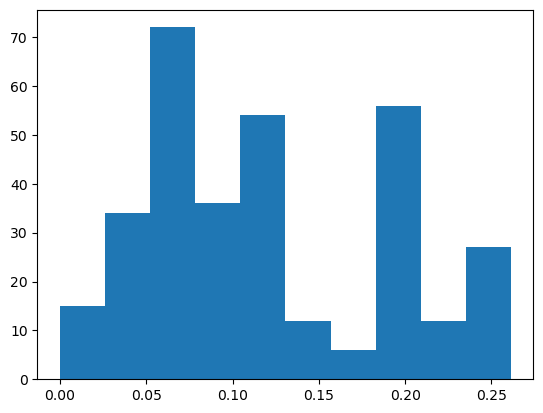

In [10]:
from matplotlib import pyplot as plt


pic = plt.hist(wf.eigenvalues.pull(), bins=10)

tuple

In [6]:
from python.pyironflow import PyironFlow

pf = PyironFlow([])
pf.gui